In [1]:
#install IPython if display funct isn't working
from IPython.display import display
import pandas as pd
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import pyxdf
import mne
import sklearn
import os
import sklearn
#%matplotlib qt

In [2]:
def xdf_to_dataframe(xdf_data):
    ''' Xdf Data should be a list of streams (dictionaries)
        Function returns a dictionary of dataframes, one dataframe per stream'''
    dataframes = {}
    for stream in xdf_data:
        df = pd.DataFrame()
        data = stream['time_series']
        timestamps = stream['time_stamps']
        df['Time'] = timestamps
        chan_names, units = get_channel_names(stream['info'])
        counts = data.shape[0]
        for series, name, unit in zip(range(data.shape[1]), chan_names, units):
            df[name[0]]  = data[:, series]
            if unit:
                df[name[0] + '_Unit'] = np.repeat(unit, counts)

        for item in stream['info']:
            if item not in ['name', 'desc', 'data']:
                try:
                    df[item] = np.repeat(stream['info'][item], counts)
                except:
                    continue
        dataframes[stream['info']['name'][0]] = df
    return dataframes

def get_channel_names(info):
    channels = info['desc'][0]['channels'][0]['channel']
    names = [chan['label'] for chan in channels ]
    units = [chan['unit'] for chan in channels ]
    return names, units

In [3]:
directory = 'Data'
participants = ['Jin', 'Andy', 'Joe', 'Kait']
xdf_files = ['Fist_1.xdf', 'Fist_2.xdf','Fist_3.xdf', 'Left_20_1.xdf','Left_20_2.xdf','Left_20_3.xdf','Left_50_1.xdf','Left_50_2.xdf','Left_50_3.xdf','PalmUp_1.xdf','PalmUp_2.xdf','PalmUp_3.xdf','Right_30_1.xdf','Right_30_2.xdf','Right_30_3.xdf','Right_80_1.xdf','Right_80_2.xdf','Right_80_3.xdf',]
csv_files = ['Fist_1.csv', 'Fist_2.csv','Fist_3.csv', 'Left_20_1.csv','Left_20_2.csv','Left_20_3.csv','Left_50_1.csv','Left_50_2.csv','Left_50_3.csv','PalmUp_1.csv','PalmUp_2.csv','PalmUp_3.csv','Right_30_1.csv','Right_30_2.csv','Right_30_3.csv','Right_80_1.csv','Right_80_2.csv','Right_80_3.csv',]
for participant in participants:
    newfile = 0
    for file in xdf_files:
        data, header = pyxdf.load_xdf(os.path.join(directory, participant, file))
        data_dfs = xdf_to_dataframe(data)
        data_dfs['Thalmic Labs MyoMyo'].to_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data.columns = myo_data.columns.str.replace(' ', '')
        newfile += 1


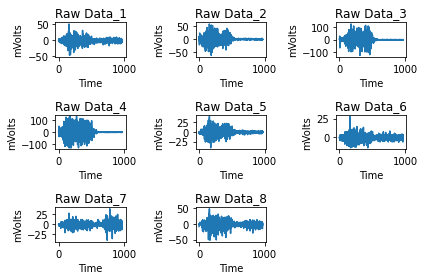

In [4]:
'''code used to look at 8 channels of raw data'''
import matplotlib.pyplot as plt
plt.figure()
for channel in range(1,9):
    plt.subplot(3,3,channel)
    ax = myo_data['EMG_' + str(channel)].plot()
    plt.title('Raw Data_' + str(channel))
    plt.ylabel('mVolts')
    plt.xlabel('Time')
    plt.tight_layout()

In [5]:
import scipy as sp
import scipy.signal

def filteremg(emg, low_pass=3, sfreq=200, high_band=20, low_band=95):
    # Zero mean emg signal
    emg = emg - emg.mean()
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    # create lowpass filter and apply to rectified signal to get EMG envelope
    #low_pass = low_pass/(sfreq/2)
    b2, a2 = sp.signal.butter(4, low_pass, fs=sfreq, btype='lowpass')
    emg_envelope = sp.signal.lfilter(b2, a2, emg_rectified)
    return emg_envelope

def notchfilter(emg, sfreq=256, notch_freq = 60, quality_factor = 20):
    b_notch, a_notch = sp.signal.iirnotch(notch_freq, quality_factor, sfreq)
    output = sp.signal.filtfilt(b_notch, a_notch, emg)
    return output

In [6]:
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)
        #plt.figure()
        #for channel in range(1,9):
            #plt.subplot(3,3,channel)
            #ax = myo_notch['EMG_' + str(channel)].plot()
            #plt.title('Total Filter_' + str(channel))
            #plt.ylabel('mVolts')
            #plt.xlabel('Time')
            #plt.tight_layout()
        newfile += 1

In [7]:
'''Extract the PSD and find the Max Power of each sample and signal'''
PSD=[]
PSD_Row = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

        '''Copy the myo_notch files'''
        myo_PSD = myo_notch.copy() #Copy the notched data into PSD
        #myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        for channel in range(1,9):
            Freq, P_Den = sp.signal.periodogram(myo_PSD['EMG_'+str(channel)],200)
            bigP_Den = max(P_Den)
            T_bigP_Den = np.transpose(bigP_Den)
            PSD_Row.append(T_bigP_Den)
            '''This get all 8 channel max PSD'''
        newfile += 1
        PSD.append([PSD_Row])
        '''Add the channel into an list'''
        PSD_Row = [] #Reset the TempRow
PSD_df= pd.DataFrame(PSD,columns=['MaxPSD_1'])
PSD_df_1= pd.DataFrame(PSD_df['MaxPSD_1'].tolist()).add_prefix('Max_PSDCh')
display(PSD_df_1)



,Max_PSDCh0,Max_PSDCh1,Max_PSDCh2,Max_PSDCh3,Max_PSDCh4,Max_PSDCh5,Max_PSDCh6,Max_PSDCh7
0,7.652409,0.870480,1.253394,0.163127,0.524881,4.889725,1.258820,2.036323
1,5.993175,0.916624,1.370589,0.064929,0.371108,4.699208,0.257998,0.825740
2,11.189908,1.430859,2.469341,0.133657,0.532599,5.552706,1.926788,2.557298
3,0.019743,0.005509,0.001627,0.001724,0.003490,0.142551,3.337406,0.097002
4,0.003730,0.001209,0.001250,0.002526,0.002793,0.021635,2.222792,0.063459
...,...,...,...,...,...,...,...,...
67,0.274230,1.335306,3.025513,0.782235,0.051268,0.083294,1.576973,3.392395
68,0.161785,0.625879,0.206804,0.698414,0.029966,0.091672,2.444174,4.300933
69,0.304201,1.971109,3.671105,15.175392,0.165946,0.025881,0.802250,1.204990
70,0.636367,3.774936,16.319276,25.054576,0.526915,0.065198,0.469723,1.639677


In [8]:
'''Exctract Mean signals'''
Mean_df=[]
Mean_Temp = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

        '''Copy the myo_notch files'''
        myo_Mean = myo_notch.copy() #Copy the notched data into PSD
        #myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        for channel in range(1,9):
            '''Add the Mean code here'''
            Mean_1 = np.mean(myo_Mean['EMG_'+str(channel)]) #Extracgt one channel of the mean
            '''This get all 8 channel max PSD'''
            Mean_Temp.append(Mean_1)
        newfile += 1
        Mean_df.append([Mean_Temp])
        Mean_Temp = [] #Reset the TempRow
display(Mean_df)
Mean_df= pd.DataFrame(Mean_df,columns=['avg'])
display(Mean_df)
Mean_df_1= pd.DataFrame(Mean_df['avg'].tolist()).add_prefix('Mean_Ch')
display(Mean_df_1)


[[[2.461753291481406,
   0.8843668088463501,
   1.0489416432597216,
   0.4814698818466594,
   0.7491862179852972,
   2.038326241456547,
   1.4676866333823022,
   1.522724220787487]],
 [[1.8528222964806629,
   0.7247863064268911,
   0.8479929685992114,
   0.36458761252829325,
   0.5130265774808761,
   1.459985287287841,
   1.2401718625415503,
   1.0487637075280092]],
 [[1.5048858606027422,
   0.6072918725804626,
   0.7545835739486411,
   0.2812938239496816,
   0.45047876290534966,
   1.22711444133577,
   1.2612325503692747,
   0.961251611294792]],
 [[0.16477691315284598,
   0.10259669341262793,
   0.09878056715657099,
   0.10791186797037514,
   0.14208348860186934,
   0.41353999210156045,
   1.5669554831158727,
   0.3464298982163555]],
 [[0.1370789229634748,
   0.09450485331716377,
   0.09867571357894099,
   0.1075677379629067,
   0.1440000157733171,
   0.4422880302923743,
   1.7342480438165382,
   0.3522311522113213]],
 [[0.19864020324002016,
   0.17372329706633324,
   0.10808771120410

,avg
0,"[2.461753291481406, 0.8843668088463501, 1.0489..."
1,"[1.8528222964806629, 0.7247863064268911, 0.847..."
2,"[1.5048858606027422, 0.6072918725804626, 0.754..."
3,"[0.16477691315284598, 0.10259669341262793, 0.0..."
4,"[0.1370789229634748, 0.09450485331716377, 0.09..."
...,...
67,"[0.41053776108963513, 0.7419439497584817, 0.85..."
68,"[0.37509480717942795, 0.5063354138779355, 0.41..."
69,"[0.534697236023656, 0.9733006418973684, 1.3435..."
70,"[0.5652408019061802, 0.8769867434820473, 1.773..."


,Mean_Ch0,Mean_Ch1,Mean_Ch2,Mean_Ch3,Mean_Ch4,Mean_Ch5,Mean_Ch6,Mean_Ch7
0,2.461753,0.884367,1.048942,0.481470,0.749186,2.038326,1.467687,1.522724
1,1.852822,0.724786,0.847993,0.364588,0.513027,1.459985,1.240172,1.048764
2,1.504886,0.607292,0.754584,0.281294,0.450479,1.227114,1.261233,0.961252
3,0.164777,0.102597,0.098781,0.107912,0.142083,0.413540,1.566955,0.346430
4,0.137079,0.094505,0.098676,0.107568,0.144000,0.442288,1.734248,0.352231
...,...,...,...,...,...,...,...,...
67,0.410538,0.741944,0.859613,0.568007,0.237389,0.303956,1.194214,1.180386
68,0.375095,0.506335,0.410133,0.680542,0.245085,0.340759,1.259805,1.434972
69,0.534697,0.973301,1.343583,2.568084,0.393347,0.302943,0.797412,1.248650
70,0.565241,0.876987,1.773320,2.310082,0.448031,0.313892,0.939398,0.910618


In [9]:
'''Standard Deviation'''
#std
std=[]
std_Row = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_datakeys = ['EMG' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_datakeys = ['EMG' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)
        '''Copy the myo_notch files'''
        myo_STD= myo_notch.copy() #Copy the notched data
        for channel in range(1,9):
            std_temp = np.std(myo_STD['EMG_'+str(channel)])
            T_std_temp = np.transpose(std_temp)
            std_Row.append(T_std_temp)
            '''This get all 8 channel max PSD'''
        newfile += 1
        std.append([std_Row])
        std_Row = [] #Reset the TempRow
std_df= pd.DataFrame(std,columns=['STD'])
std_df_1= pd.DataFrame(std_df['STD'].tolist()).add_prefix('STD_Ch')
display(std_df_1)

,STD_Ch0,STD_Ch1,STD_Ch2,STD_Ch3,STD_Ch4,STD_Ch5,STD_Ch6,STD_Ch7
0,1.598083,0.538037,0.697017,0.272103,0.452000,1.225126,0.717386,0.824354
1,1.307164,0.483155,0.558576,0.154024,0.293552,0.966567,0.442312,0.554177
2,1.283871,0.481421,0.619158,0.157426,0.291940,0.908751,0.595076,0.643937
3,0.082071,0.046922,0.036009,0.032963,0.042683,0.209884,0.893496,0.196601
4,0.050085,0.028896,0.033830,0.048953,0.046327,0.156390,0.905133,0.169012
...,...,...,...,...,...,...,...,...
67,0.297708,0.609953,0.956086,0.460652,0.122881,0.167656,0.741006,1.014071
68,0.216849,0.403277,0.328214,0.443161,0.109468,0.167925,0.791170,1.052261
69,0.366439,0.862780,1.123683,2.154211,0.227617,0.133867,0.755354,0.717546
70,0.438780,1.005547,2.031488,2.400223,0.366349,0.169035,0.482770,0.695728


In [10]:
'''Merge all three features into a big ass dataframe'''
Feature_df = pd.concat([PSD_df_1,Mean_df_1,std_df_1],axis=1,join = 'outer')
display(Feature_df)


,Max_PSDCh0,Max_PSDCh1,Max_PSDCh2,Max_PSDCh3,Max_PSDCh4,Max_PSDCh5,Max_PSDCh6,Max_PSDCh7,Mean_Ch0,Mean_Ch1,...,Mean_Ch6,Mean_Ch7,STD_Ch0,STD_Ch1,STD_Ch2,STD_Ch3,STD_Ch4,STD_Ch5,STD_Ch6,STD_Ch7
0,7.652409,0.870480,1.253394,0.163127,0.524881,4.889725,1.258820,2.036323,2.461753,0.884367,...,1.467687,1.522724,1.598083,0.538037,0.697017,0.272103,0.452000,1.225126,0.717386,0.824354
1,5.993175,0.916624,1.370589,0.064929,0.371108,4.699208,0.257998,0.825740,1.852822,0.724786,...,1.240172,1.048764,1.307164,0.483155,0.558576,0.154024,0.293552,0.966567,0.442312,0.554177
2,11.189908,1.430859,2.469341,0.133657,0.532599,5.552706,1.926788,2.557298,1.504886,0.607292,...,1.261233,0.961252,1.283871,0.481421,0.619158,0.157426,0.291940,0.908751,0.595076,0.643937
3,0.019743,0.005509,0.001627,0.001724,0.003490,0.142551,3.337406,0.097002,0.164777,0.102597,...,1.566955,0.346430,0.082071,0.046922,0.036009,0.032963,0.042683,0.209884,0.893496,0.196601
4,0.003730,0.001209,0.001250,0.002526,0.002793,0.021635,2.222792,0.063459,0.137079,0.094505,...,1.734248,0.352231,0.050085,0.028896,0.033830,0.048953,0.046327,0.156390,0.905133,0.169012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.274230,1.335306,3.025513,0.782235,0.051268,0.083294,1.576973,3.392395,0.410538,0.741944,...,1.194214,1.180386,0.297708,0.609953,0.956086,0.460652,0.122881,0.167656,0.741006,1.014071
68,0.161785,0.625879,0.206804,0.698414,0.029966,0.091672,2.444174,4.300933,0.375095,0.506335,...,1.259805,1.434972,0.216849,0.403277,0.328214,0.443161,0.109468,0.167925,0.791170,1.052261
69,0.304201,1.971109,3.671105,15.175392,0.165946,0.025881,0.802250,1.204990,0.534697,0.973301,...,0.797412,1.248650,0.366439,0.862780,1.123683,2.154211,0.227617,0.133867,0.755354,0.717546
70,0.636367,3.774936,16.319276,25.054576,0.526915,0.065198,0.469723,1.639677,0.565241,0.876987,...,0.939398,0.910618,0.438780,1.005547,2.031488,2.400223,0.366349,0.169035,0.482770,0.695728


In [11]:
'''Time to do PCA Pipline'''
#from sklearn.decomposition import  PCA
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

#CA_Feat= make_pipeline(StandardScaler(), PCA(n_components=7, svd_solver='full'))


In [12]:
'''Run the PCA Pipeline'''
#Pip_fit = PCA_Feat.fit(Feature_df)
#T_PCA_Feat =PCA_Feat.transform(Feature_df)
#var_PCA = T_PCA_Feat.explained_variance_ratio
#display(Pip_fit)
#print(Pip_fit.explained_variance_ratio_)


AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio'

In [ ]:
#pca

#svm
#kmeans
classes = ['Fist', 'Slight Left', 'Hard Left','Palm Up', 'Slight Right', 'Hard Right']
svmClass_df = pd.DataFrame({"Class":['Fist','Fist','Fist', 'Slight Left','Slight Left','Slight Left', 'Hard Left','Hard Left','Hard Left','Palm Up','Palm Up','Palm Up', 'Slight Right','Slight Right','Slight Right', 'Hard Right','Hard Right','Hard Right']})
svmFeature_df = pd.concat([svmClass_df,PSD_df_1,Mean_df_1,std_df_1],axis=1,join = 'outer')
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
'''We are going to do Leave-One-Out Cross Validation'''
groups = svmFeature_df['Class'].values # Specify groups
svm_X = Feature_df.values # specify Feature columns
'''Create our Labels from Categories'''
le = LabelEncoder()
le.fit(svmFeature_df['Class'].values) # Specify Classes
svm_y = le.transform(svmFeature_df['Class'].values) # Transform categories into class labels
#display(svm_y)

''' Initialize groups'''
svm_logo = LeaveOneGroupOut()
'''Look at how many groups we have (should be the number of participants)'''
svm_logo.get_n_splits(svm_X, svm_y, groups)
svm_predicted = np.array([])
svm_true = np.array([])

'''We can create a classifaction pipeline'''
svm_clf = make_pipeline(StandardScaler(), # Standardize the inputs
                    PCA(n_components=0.9, svd_solver='full'),  # PCA with 0.9 as the threshold for explain variance
                    SVC(kernel='linear', gamma='auto', class_weight='balanced')) # SVM with RBF kernel
#rbf, linear, poly
''' We can cycle through each group, fit our model, and record our results'''
for train_index, test_index in svm_logo.split(svm_X, svm_y, groups):
    X_train, X_test = svm_X[train_index], svm_X[test_index] # get x training/testing
    y_train, y_test = svm_y[train_index], svm_y[test_index] # get y training/testing
    svm_clf.fit(X_train, y_train) # fit our model
    svm_predicted = np.hstack((svm_predicted, svm_clf.predict(X_test)))
    svm_true = np.hstack((svm_true, y_test))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
'''View Results'''
display(pd.DataFrame(classification_report(svm_true, svm_predicted,output_dict=True)).transpose())

cm = confusion_matrix(svm_true, svm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier()
rfFeature_df = pd.concat([svmClass_df,PSD_df_1,Mean_df_1,std_df_1],axis=1,join = 'outer')
rfX = rfFeature_df.drop('Class', axis = 1) # specify Feature columns
'''Create our Labels from Categories'''
rfle = LabelEncoder()
rfle.fit(rfFeature_df['Class'].values) # Specify Classes
rfy = rfle.transform(rfFeature_df['Class'].values)


# Split dataset into training set and test set
rfX_train, rfX_test, rfy_train, rfy_test = train_test_split(rfX, rfy, test_size=0.3)
rf_clf = make_pipeline(StandardScaler(),
                    PCA(n_components=0.9, svd_solver='full'),
                    RandomForestClassifier(n_estimators = 50, max_depth = 4))
rf_clf.fit(rfX_train,rfy_train)

rf_model.fit(rfX_train, rfy_train) #rfy_train.index
rfy_pred=rf_clf.predict(rfX_test)
print("Accuracy:",metrics.accuracy_score(rfy_test, rfy_pred))
rf_predictions = rf_model.predict(rfX_train)
print("Accuracy Score:",accuracy_score(rfy_train, rf_predictions))
importance_1 = rf_model.feature_importances_
set_importances = pd.Series(importance_1, index=Feature_df.columns)
#importances = importances.sort_values(by='Importance', ascending=False)
#rf rand forest
#print(importances)
p = set_importances.plot(x='features', y='importances', kind='bar', color='r', alpha=0.5, title = "Feature Importance", xlabel = "Features" , ylabel = "Importance")

#confusion matrix
#accuracy

In [ ]:
rfX=pd.DataFrame({'Features':["['Max_PSDCh0', 'Max_PSDCh1', 'Max_PSDCh2', 'Max_PSDCh3', 'Max_PSDCh4',
       'Max_PSDCh5', 'Max_PSDCh6', 'Max_PSDCh7', 'Mean_Ch0', 'Mean_Ch1',
       'Mean_Ch2', 'Mean_Ch3', 'Mean_Ch4', 'Mean_Ch5', 'Mean_Ch6', 'Mean_Ch7',
       'STD_Ch0', 'STD_Ch1', 'STD_Ch2', 'STD_Ch3', 'STD_Ch4', 'STD_Ch5',
       'STD_Ch6', 'STD_Ch7']})  # Features
rfy=rf_df['Class']  # Labels

importances = pd.DataFrame(rfFeature_df, columns ={
    'Attribute': rfX_train.columns,
    'Importance': rf_model.coef_[0]
})